In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Start virtual display
# pip install PyVirtualDisplay
# sudo apt-get install xvfb

from pyvirtualdisplay import Display
display = Display(visible=0, size=(1024, 768))
display.start()
import os
os.environ["DISPLAY"] = ":" + str(display.display) + "." + str(display.screen)

In [3]:
from REINFORCE_helper import RunningVariance
from time import time
from REINFORCE_helper import BaseAgent, format_as_pandas
from keras.models import Sequential, Model
from keras.layers import Dense, Input
from keras.optimizers import Adam, SGD
import keras.backend as K
import numpy as np

Using TensorFlow backend.


In [102]:
class ReinforceAgent(BaseAgent):
    # def __init__(self):
    def actor_critic_loss_continuous(self, advantage):
        def loss(y_true, y_pred):
            var = K.square(self.noise)
            denom = K.sqrt(2.0 * np.pi * var)
            prob_num = K.exp(- K.square(y_true - y_pred) / (2.0 * var))
            prob = prob_num/denom
            return -K.mean(prob * advantage)
        return loss
    
    def get_policy_model(self, lr=0.001, hidden_layer_neurons = 128, input_shape=[4], output_shape=2):
        state_input = Input(shape=input_shape)
        advantage = Input(shape=(1,))
        x = Dense(hidden_layer_neurons, activation='relu')(state_input)
        x = Dense(hidden_layer_neurons, activation='relu')(x)
        out_actions = Dense(output_shape, activation='tanh')(x)
        
        model = Model(inputs=[state_input, advantage], outputs=[out_actions])
        model.compile(Adam(lr), loss=self.actor_critic_loss_continuous(advantage))
        return model
    
    def get_action(self, eval=False):
        dummy_adv = np.zeros((1, 1))
        obs = self.scaler.transform(self.observation.reshape(1, self.nS))
        p = self.model.predict([obs, dummy_adv])*self.env.action_space.high
        if eval is False:
            action = action_one_hot = p[0] + np.random.normal(loc=0, scale=self.noise, size=p[0].shape)
            # action = action_one_hot = np.clip(action, self.env.action_space.low, self.env.action_space.high)
        else:
            action = action_one_hot = p[0]
        
        return action, action_one_hot, p
    
    
    def get_entropy(self, preds, epsilon=1e-12):
        # entropy = np.mean(-np.sum(np.log(preds+epsilon)*preds, axis=1)/np.log(self.nA))
        return 1
    
    def get_discounted_rewards(self, r):
        # Por si es una lista
        r = np.array(r, dtype=float)
        """Take 1D float array of rewards and compute discounted reward """
        discounted_r = np.zeros_like(r)
        running_add = 0
        for t in reversed(range(0, r.size)):
            running_add = running_add * self.gamma + r[t]
            discounted_r[t] = running_add
        return discounted_r 

In [103]:
# reinforce_agent = ReinforceAgent('MountainCarContinuous-v0', n_experience_episodes=2, EPISODES=2000, epochs=1, lr=0.001, algorithm='REINFORCE_CAUSAL')
reinforce_agent = ReinforceAgent('Pendulum-v0', n_experience_episodes=2, EPISODES=2000, epochs=1, lr=0.001, algorithm='REINFORCE_CAUSAL')

In [104]:
print(reinforce_agent.env.action_space.low,
reinforce_agent.env.action_space.high)

[-2.] [2.]


In [105]:
reinforce_agent.model.summary()

Model: "model_44"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_87 (InputLayer)        (None, 3)                 0         
_________________________________________________________________
dense_87 (Dense)             (None, 128)               512       
_________________________________________________________________
dense_88 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_89 (Dense)             (None, 1)                 129       
Total params: 17,153
Trainable params: 17,153
Non-trainable params: 0
_________________________________________________________________


In [93]:
obs, actions, preds, disc_sum_rews, rewards, ep_returns, ep_len, last_obs, time_step = reinforce_agent.get_experience_episodes(return_ts=True)

In [94]:
print(actions[:10])

[[ 0.36114624]
 [-0.42074557]
 [ 0.6688807 ]
 [-0.92075621]
 [ 1.05991216]
 [ 1.03843525]
 [-0.00721554]
 [ 0.15000625]
 [ 0.32128172]
 [-0.24326977]]


In [95]:
print(preds[:10])

[[-0.45008335]
 [-0.42323685]
 [-0.38358575]
 [-0.33727542]
 [-0.28008452]
 [-0.22031565]
 [-0.15635855]
 [-0.10698768]
 [-0.05212078]
 [-0.00946408]]


In [96]:
obs

array([[ 0.98309396, -0.18310182, -0.67377843],
       [ 0.97546183, -0.22016862, -0.75693285],
       [ 0.96343783, -0.26793198, -0.98517115],
       ...,
       [-0.99940213, -0.03457426,  1.12025402],
       [-0.997022  , -0.07711764,  0.85226262],
       [-0.99275453, -0.12016004,  0.86513613]])

In [ ]:
# reinforce_agent = ReinforceAgent('MountainCarContinuous-v0', n_experience_episodes=1, 
#                                  EPISODES=2000, epochs=1, lr=0.0001, algorithm='CONTINUOUS_CAUSAL', noise=1.5)

reinforce_agent = ReinforceAgent('Pendulum-v0', n_experience_episodes=1, 
                                 EPISODES=10000, epochs=1, lr=0.0001, algorithm='CONTINUOUS_CAUSAL', noise=2.0)

initial_time = time()
running_variance = RunningVariance()


while reinforce_agent.episode < reinforce_agent.EPISODES:
    obs, actions, preds, disc_sum_rews, rewards, ep_returns, ep_len, last_obs = reinforce_agent.get_experience_episodes()
    
    for dr in disc_sum_rews:
        running_variance.add(dr)

    
    history = reinforce_agent.model.fit([obs, disc_sum_rews.reshape(-1, 1)], 
                                        actions, verbose=0, 
                                        epochs=reinforce_agent.epochs, 
                                        batch_size=1)
    
    reinforce_agent.log_data(reinforce_agent.episode, 
                      history.history['loss'][0], 
                      np.mean(ep_len), 
                      reinforce_agent.get_entropy(preds), 
                      running_variance.get_variance(), 
                      None, 
                      time() - initial_time, np.mean(ep_returns[-1]))

correr en linea de comando: tensorboard --logdir logs/
Episode: 50
Model on episode 51 improved from -inf to -1483.051074865203. Saved!
Episode: 102
Model on episode 103 improved from -1483.051074865203 to -1476.4650769870486. Saved!
Episode: 206
Model on episode 207 improved from -1476.4650769870486 to -1473.8844601800115. Saved!
Episode: 1038
Model on episode 1039 improved from -1404.9479166598744 to -1370.6277389063318. Saved!
Episode: 6577

In [51]:
from matplotlib import pyplot as plt

In [53]:
# obs, actions, preds, disc_sum_rews, rewards, ep_returns, ep_len = reinforce_agent.get_eval_episode('MountainCarContinuous.gif', fps=50)
obs, actions, preds, disc_sum_rews, rewards, ep_returns, ep_len = reinforce_agent.get_eval_episode()

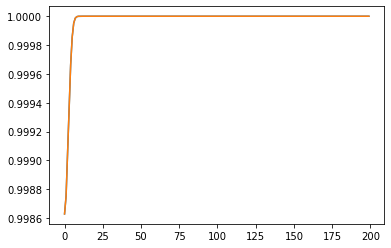

In [54]:
plt.plot(preds)
plt.plot(actions)

In [49]:
obs, actions, preds, disc_sum_rews, rewards, ep_returns, ep_len, last_obs = reinforce_agent.get_experience_episodes()

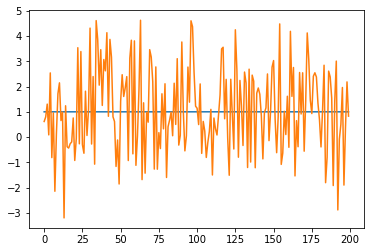

In [52]:
plt.plot(preds)
plt.plot(actions)